In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys, subprocess, time, pdb
import itertools, uuid
import numpy as np
import scipy
from scipy.stats import pearsonr
from tqdm.auto import tqdm, trange
import matplotlib
import matplotlib.pyplot as plt

sys.path.insert(0, '../network')
from measures import *

#### Load data

In [3]:
directory2 = "3-nonlinear-phase-diagram/data/"
keys=['I_ext_1','I_ext_2']
ds = DataStore(directory2)
n1, n2 = 54, 40
ds.load()
ds.process(keys)

  0%|          | 0/2120 [00:00<?, ?it/s]

In [95]:
def slice_data(ds, output, keys, raise_on_error=False):
    for idxs, vals in zip(
        itertools.product(*[range(len(ds.keyvals[key])) for key in keys]),
        itertools.product(*[ds.keyvals[key] for key in keys])):
        try:
            output[idxs] = ds.data[vals]
        except:
            if raise_on_error:
                raise StandardError

@np.vectorize
def quality(val):
    try:
        return val['q'][-1,:].max()
    except:
        return np.NaN
    
@np.vectorize
def speed(val):
    try:
        q = val['q']
        idxs = q.argmax(axis=1)
        diffs = np.diff(idxs)
        diffs = diffs[np.logical_and(
            np.logical_and(
                diffs < diffs.mean()+2*diffs.std(),
                diffs > diffs.mean()-2*diffs.std()),
            diffs > 0)]
        return np.mean(diffs)
    except:
        return np.NaN
    
@np.vectorize
def persistent_quality(val):
    try:
        return val['q'][0,-1]
    except:
        return np.NaN
    
@np.vectorize 
def incomplete_sequential_to_persistent(val):
    "Incomplete sequential activity, followed by persistent activity of one of the patterns"
    try:
        # Test whether 8th pattern was retrieved (i.e. if full sequential retrieval occured)
        a = val['q'][7,:]
        b = val['q'][8:,:].mean(axis=0) + 2*val['q'][8:,:].std(axis=0)
        cond_1 = np.any(a > b)
        
        if not cond_1:
            # If full retrieval did not occur, then test if there is persistent activity of 
            # the first 8 patterns within the second half of the simulation
            b = val['q'][8:,1000:].mean(axis=0) + 2*val['q'][8:,1000:].std(axis=0)
            for i in range(8):
                a = val['q'][i,1000:]
                if np.all(a > b):
                    return True
            return False
        else:
            return False
    except:
        return np.NaN
    
@np.vectorize 
def persistent_activity(val):
    "Persistent activity of the first pattern"
    try:
        a = val['q'][0,:]#.mean()
        b = val['q'][1:,:].mean(axis=0) + 2*val['q'][1:,:].std(axis=0)
        return np.all(a > b)
    except:
        return np.NaN

Retrieve overlaps to plot in the 3 panels

In [6]:
output = np.zeros((n1,n2), dtype=object)
slice_data(ds, output, keys)

i1, j1 = 16-7+13, 24
i2, j2 = 16+0+13, 24
i3, j3 = 16+7+13, 24

In [7]:
ext1 = ds.keyvals['I_ext_1']
ext2 = ds.keyvals['I_ext_2']

def get_overlaps(i,j):
    "Return overlaps for population 1 and 2"
    m1 = ds.data[ext1[i],ext2[j]]['q1']
    m2 = ds.data[ext1[i],ext2[j]]['q2']
    return m1, m2

m1a, m2a = get_overlaps(i1,j1)
m1b, m2b = get_overlaps(i2,j2)
m1c, m2c = get_overlaps(i3,j3)

Manually exclude 5 points that are artifacts due to spurious correlation arising from zero firing rate (checked in separate simulation)

(array([26, 28, 30, 32, 34]), array([ 0,  3,  6,  9, 12]))

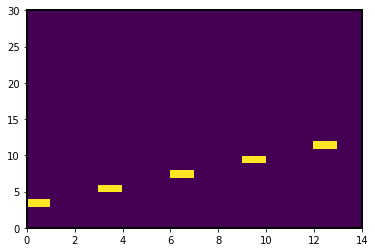

In [141]:
output = np.zeros((n1,n2), dtype=object)
slice_data(ds, output, keys)
tmp = incomplete_sequential_to_persistent(output)
offset_x = 23
plt.pcolor(tmp[offset_x:-1,:14])
exclude_i, exclude_j = tmp[offset_x:-1,:14].nonzero()
exclude_i += offset_x
exclude_i, exclude_j

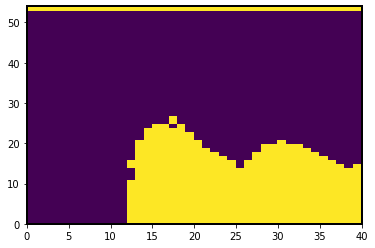

In [142]:
for i,j in zip(exclude_i, exclude_j):
    tmp[i,j] = 0
plt.pcolor(tmp)

#### Figure

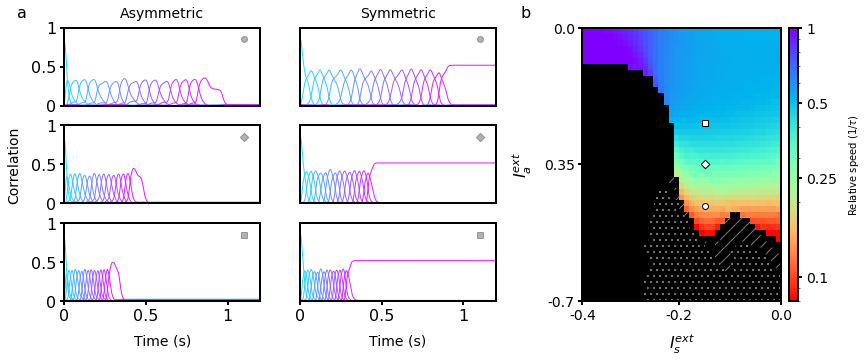

In [143]:
import matplotlib
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
matplotlib.rcParams['axes.linewidth'] = 2

fig = plt.figure(constrained_layout=False, figsize=(12,4))
gs1 = fig.add_gridspec(nrows=3, ncols=2,
                       left=0.05, right=0.55, top=0.95, bottom=0,
                       hspace=0.25, wspace=0.2)
ax1 = fig.add_subplot(gs1[0,0])
ax2 = fig.add_subplot(gs1[1,0])
ax3 = fig.add_subplot(gs1[2,0])
ax4 = fig.add_subplot(gs1[0,1])
ax5 = fig.add_subplot(gs1[1,1])
ax6 = fig.add_subplot(gs1[2,1])
ax = np.asarray([[ax1, ax2, ax3], [ax4, ax5, ax6]]).T

gs2 = fig.add_gridspec(nrows=1, ncols=1, 
                       left=0.65, right=0.9, top=0.95, bottom=0.0)
ax7 = fig.add_subplot(gs2[:,:])

## -----------------------------------------------------------
## ------- Panel a -------------------------------------------
## -----------------------------------------------------------

cmap = matplotlib.cm.get_cmap('cool')
colors_ = [cmap(x) for x in np.linspace(0.1,0.9,16)]

T = 2
dt = 1e-3
t = np.arange(0,T,dt)

for i, m in enumerate(ds.data[ext1[i1],ext2[j1]]['q1']):
    ax[0,0].plot(t,m, linewidth=1, c=colors_[i]);
for i, m in enumerate(ds.data[ext1[i2],ext2[j2]]['q1']):
    ax[1,0].plot(t,m, linewidth=1, c=colors_[i]);
for i, m in enumerate(ds.data[ext1[i3],ext2[j3]]['q1']):
    ax[2,0].plot(t,m, linewidth=1, c=colors_[i]);
    
for i, m in enumerate(ds.data[ext1[i1],ext2[j1]]['q2']):
    ax[0,1].plot(t,m, linewidth=1, c=colors_[i]);
for i, m in enumerate(ds.data[ext1[i2],ext2[j2]]['q2']):
    ax[1,1].plot(t,m, linewidth=1, c=colors_[i]);
for i, m in enumerate(ds.data[ext1[i3],ext2[j3]]['q2']):
    ax[2,1].plot(t,m, linewidth=1, c=colors_[i]);
    
for i,marker in enumerate(['o','D','s']):
    ax[i,0].scatter(1.1,0.85, color='k', marker=marker, alpha=0.3)
    ax[i,1].scatter(1.1,0.85, color='k', marker=marker, alpha=0.3)
    
for i in range(3):
    ax[i,0].set_xlim([0,1.2])
    ax[i,0].set_ylim([0,1.])
    ax[i,0].set_yticklabels([0,0.5,1], fontsize=16)
    ax[i,1].set_xlim([0,1.2])
    ax[i,1].set_ylim([0,1.])
    ax[i,1].set_yticks([])
    if i < 2:
        ax[i,0].set_xticks([])
        ax[i,1].set_xticks([])
for i in range(2):
    ax[-1,i].set_xticks([0,0.5,1])
    ax[-1,i].set_xticklabels([0,0.5,1], fontsize=16)
    
ax[-1,0].set_xlabel("Time (s)", fontsize=14, labelpad=10)
ax[-1,1].set_xlabel("Time (s)", fontsize=14, labelpad=10)
ax[1,0].set_ylabel("Correlation", fontsize=14, labelpad=10)

ax[0,0].set_title("Asymmetric", fontsize=14, pad=10)
ax[0,1].set_title("Symmetric", fontsize=14, pad=10)

## -----------------------------------------------------------
## ------- Panel b -------------------------------------------
## -----------------------------------------------------------

output = np.zeros((n1,n2), dtype=object)
slice_data(ds, output, keys)
tmp = speed(output)
tmp2 = quality(output)
tmp[tmp2<0.05] = np.inf
tmp[np.isnan(tmp)] = np.inf
cm = matplotlib.cm.get_cmap('rainbow_r')
cm.set_bad(color='k')
tau = 10.
tmp = tau/tmp
X, Y = np.meshgrid(np.arange(n2),np.arange(n1))
im1 = ax7.pcolor(X,Y,tmp, cmap=cm,
                rasterized=True,
                norm=colors.LogNorm(vmin=0.08, vmax=10/10.))

# Persistent activity
# Exclude a few artifact points (see note in above cell)
tmp3 = persistent_activity(output)
tmp3[tmp3 == True] = 1
tmp3[tmp3 == False] = 0
for i,j in zip(exclude_i, exclude_j):
    tmp3[i,j] = 0
ZM = np.ma.masked_equal(tmp3, 0)
plt.rcParams.update({'hatch.color': 'grey'})
cset = ax7.pcolor(X, Y, ZM, rasterized=True, alpha=0, hatch='..')

# Persistent activity of intermediate pattern (not the first pattern)
# Exclude a few artifact points (see note in above cell)
tmp4 = incomplete_sequential_to_persistent(output)
tmp4[tmp4 == True] = 1
tmp4[tmp4 == False] = 0
tmp4[tmp3 == True] = 0 
for i,j in zip(exclude_i, exclude_j):
    tmp4[i,j] = 0
ZM = np.ma.masked_equal(tmp4, 0)
plt.rcParams.update({'hatch.color': 'grey'})
cset = ax7.pcolor(X, Y, ZM, rasterized=True, alpha=0, hatch='//')

divider = make_axes_locatable(ax7)
cax = divider.append_axes('right', size='5%', pad=0.10)
cb = fig.colorbar(im1, cax=cax, ticks=[0.1,0.25,0.5,1]);
cb.set_label(r"Relative speed ($1/\tau$)", labelpad=10)
cb.ax.set_yticklabels([0.1,0.25,0.5,1])
cb.ax.tick_params(width=2, length=4, labelsize=14)

yticks, xticks = [list(["%.1f"%y for y in x]) for x in ds.keyvals.values()]
yticks[29] = "0.35" # Fix rounding tick error
ax7.set_xticks([0,19,39])
ax7.set_yticks([6,29,52])
ax7.set_xticklabels([xticks[i] for i in [0,19,39]], fontsize=14)
ax7.set_yticklabels([yticks[i] for i in [6,29,52]], fontsize=14)
ax7.set_xlabel(r"$I^{ext}_s$", fontsize=16, labelpad=10)
ax7.set_ylabel(r"$I^{ext}_a$", fontsize=16, labelpad=10)
ax7.set_ylim([6,52])

for (i,j,marker) in [(i1,j1,'o'),(i2,j2,'D',),(i3,j3,'s')][:]:
    ax7.scatter(j,i,color='white',marker=marker, edgecolors='k')
    
plt.annotate(s="a", xy=(0.02,0.95), xycoords='figure fraction', fontsize=16);
plt.annotate(s="b", xy=(0.60,0.95), xycoords='figure fraction', fontsize=16);

for ax in [ax1, ax2, ax3, ax4, ax5, ax6, ax7]:
    ax.tick_params(width=2, length=4)

fig.savefig("3.pdf", dpi=150, bbox_inches='tight')